# Devoir - Ensembles, Applications & Dénombrement

**Objectif du devoir**  
Valider les fondamentaux sur les **ensembles**, les **applications (fonctions)** et le **dénombrement**, en mobilisant Python comme outil d'expérimentation et de preuve par le calcul.

**Règles & rendu**
- Travail **individuel** (vous pouvez discuter, mais le code/texte final doit être personnel).
- Autorisé : `math`, `itertools`, `collections`, `matplotlib.pyplot`. **Interdit** : bibliothèques externes.
- Rendez ce notebook **exécuté** (toutes les sorties présentes), nommé : `NOM_Prenom_Dev_Ensembles_Fonctions_Denombrement.ipynb`.
- **Évaluation (120 pts)** : Q1 (10) · Q2 (10) · Q3 (10) · Q4 (10) · Q5 (10) · Q6 (10) · Q7 (10) · Q8 (10) · Q9 (10) · Q10 (20) · Présentation/Clarté (10).

> Astuce : commentez vos choix, montrez des essais, et utilisez des fonctions utilitaires réutilisables.

### Fonctions utilitaires (à compléter si besoin)

In [ ]:
from itertools import product, combinations, permutations
from collections import Counter
import math
import matplotlib.pyplot as plt

def cartesian(A, B):
    """Produit cartésien A×B sous forme d'ensemble de couples (a, b).
    Paramètres:
      - A, B: itérables représentant des ensembles.
    Retourne:
      - Un set de tuples (a, b) pour a∈A et b∈B.
    """
    return {(a, b) for a in A for b in B}

def powerset(s):
    """Ensemble des parties (power set) d'un ensemble fini s.
    Remarque: les sous-ensembles sont représentés par des frozenset pour être hashables.
    """
    s = list(s)
    P = []
    n = len(s)
    for mask in range(1 << n):
        subset = frozenset(s[i] for i in range(n) if (mask >> i) & 1)
        P.append(subset)
    return P

def image_map(f_dict, A):
    """Image f(A) = {f(x) : x∈A et x dans le domaine de f}.
    Paramètres: f_dict (dict), A (itérable).
    """
    return {f_dict[x] for x in A if x in f_dict}

def preimage_map(f_dict, B):
    """Préimage f^{-1}(B) = {x : f(x)∈B}.
    Paramètres: f_dict (dict), B (itérable de valeurs).
    """
    return {x for x, y in f_dict.items() if y in B}

def is_application(E, F, rel, *, total=True, return_reason=False):
    """
    Vérifie si `rel` définit une application E → F.

    Paramètres
    ----------
    E, F : collections (domaines/codomaines)
    rel  : dict {x: y} OU itérable de couples (x, y)
    total : bool (par défaut True)
        - True  : application totale (chaque x∈E a exactement une image)
        - False : application partielle (chaque x∈E a AU PLUS une image)
    return_reason : bool
        - False : renvoie un booléen
        - True  : renvoie (booléen, message)

    Règles vérifiées
    ----------------
    1) Graphage dans E×F (chaque (x,y) respecte x∈E, y∈F)
    2) Unicité de l'image (pas deux images distinctes pour un même x)
    3) Totalité si total=True (chaque x∈E a une image)
    """
    E = set(E); F = set(F)

    # Normalisation (dict -> couples)
    if isinstance(rel, dict):
        pairs = list(rel.items())
    else:
        pairs = list(rel)

    # 1) Appartenance à E×F
    for (x, y) in pairs:
        if x not in E:
            msg = f"x={x!r} n'appartient pas à E"
            return (False, msg) if return_reason else False
        if y not in F:
            msg = f"y={y!r} n'appartient pas à F"
            return (False, msg) if return_reason else False

    # 2) Unicité de l'image pour chaque x
    seen = {}
    for (x, y) in pairs:
        if x in seen and seen[x] != y:
            msg = f"Non fonctionnel : {x!r} est associé à {seen[x]!r} et {y!r}"
            return (False, msg) if return_reason else False
        seen[x] = y

    # 3) Totalité (si demandée)
    if total:
        missing = E - set(seen.keys())
        if missing:
            msg = f"Pas totale : éléments de E sans image = {sorted(missing)!r}"
            return (False, msg) if return_reason else False
    else:
        # partielle : vérifie simplement qu'on ne mappe pas d'éléments hors E (déjà fait)
        pass

    return (True, "OK") if return_reason else True


def is_function(E, F, rel):
    """Teste si `rel` est le graphe d'une fonction E ⇀ F (partielle).
    Équivalent à is_application(total=False).
    """
    return is_application(E, F, rel, total=False)

def is_injective(f, E=None, F=None):
    """Vérifie l'injectivité de f.
    Paramètres:
      - f: dict représentant une application.
      - E: (optionnel) ensemble de départ attendu; si fourni, on exige dom(f)=E.
      - F: (optionnel) ensemble d'arrivée attendu; si fourni, on exige Im(f)⊆F.
    Retourne True ssi f est injective sur son domaine.
    """
    if E is not None and set(f.keys()) != set(E):
        return False
    if F is not None and not set(f.values()).issubset(set(F)):
        return False
    vals = list(f.values())
    return len(vals) == len(set(vals))

def is_surjective(f, E, F):
    """Vérifie la surjectivité de f : E → F.
    Hypothèse: la totalité n'est pas imposée ici; on vérifie seulement Im(f|_E)=F.
    Pour exiger une fonction totale, combiner avec is_application(..., total=True).
    """
    return set(f[x] for x in E if x in f) == set(F)

def is_bijective(f, E, F):
    """Vérifie la bijectivité: injective et surjective entre E et F.
    """
    return is_injective(f, E, F) and is_surjective(f, E, F)

def compose(g, f, *, strict=True):
    """Compose deux applications (g ∘ f)(x) = g(f(x)).
    - g: dict Y→Z
    - f: dict X→Y
    - strict=True: lève ValueError si f(x)∉dom(g). Si False, ignore ces x.
    """
    if strict:
        try:
            return {x: g[f[x]] for x in f}
        except KeyError as e:
            raise ValueError(f"Composition invalide: valeur {e.args[0]!r} absente du domaine de g")
    else:
        return {x: g[f[x]] for x in f if f[x] in g}

def stirling_second(n, k, memo=None):
    """Nombres de Stirling de 2e espèce S(n,k).
    Définition récursive: S(n,k) = k*S(n-1,k) + S(n-1,k-1), avec S(0,0)=1 et S(n,0)=0 pour n>0.
    Utilise une mémoïsation optionnelle.
    """
    if n < 0 or k < 0:
        return 0
    if memo is None:
        memo = {}
    key = (n, k)
    if key in memo:
        return memo[key]
    if n == 0 and k == 0:
        memo[key] = 1
    elif n == 0 or k == 0 or k > n:
        memo[key] = 0
    else:
        memo[key] = k * stirling_second(n-1, k, memo) + stirling_second(n-1, k-1, memo)
    return memo[key]

def surjections_count(m, n):
    """Nombre de surjections E→F pour |E|=m, |F|=n: n! · S(m,n); vaut 0 si m<n.
    """
    if m < n:
        return 0
    return math.factorial(n) * stirling_second(m, n)

def all_functions_count(m, n):
    """Nombre total d'applications E→F avec |E|=m, |F|=n : n^m.
    """
    return n**m

def injections_count(m, n):
    """Nombre d'injections E→F (m ≤ n): n·(n−1)·...·(n−m+1). Retourne 0 si m>n.
    """
    if m > n:
        return 0
    prod = 1
    for i in range(m):
        prod *= (n - i)
    return prod

def plot_function_arrows(E, F, f):
    """Trace un diagramme en flèches représentant f : E → F.
    Hypothèse: f est un dict partiel/total de E vers F.
    """
    Ex = sorted(list(E), key=lambda x: str(x))
    Fx = sorted(list(F), key=lambda x: str(x))
    fig = plt.figure(figsize=(6, 2.6))
    ax = plt.gca()
    for i, x in enumerate(Ex):
        ax.plot(i, 1, marker='o')
        ax.text(i, 1.08, str(x), ha='center', va='bottom')
    for j, y in enumerate(Fx):
        ax.plot(j, 0, marker='o')
        ax.text(j, -0.08, str(y), ha='center', va='top')
    for i, x in enumerate(Ex):
        y = f.get(x, None)
        if y is None:
            continue
        j = Fx.index(y)
        ax.annotate('', xy=(j, 0.08), xytext=(i, 0.92), arrowprops=dict(arrowstyle='->'))
    ax.set_xlim(-0.5, max(len(Ex), len(Fx)) - 0.5)
    ax.set_ylim(-0.5, 1.5)
    ax.axis('off')
    ax.set_title('f : E → F')
    plt.show()


## Partie A - Ensembles (30 pts)
### Q1 - Opérations de base (10 pts)

In [ ]:
A={1,2,3,4,5}; B={3,4,6,7}; U=set(range(1,11))
A_union_B=A|B; A_inter_B=A&B; A_minus_B=A-B; B_minus_A=B-A; A_comp=U-A
lhs=U-(A|B); rhs=(U-A)&(U-B); de_morgan_ok=(lhs==rhs)
A_union_B, A_inter_B, A_minus_B, B_minus_A, A_comp, de_morgan_ok

In [11]:
A = {1,2,3,4,5}; B = {3,4,6,7}; U = set(range(1,11))

A_union_B = {1, 2, 3, 4, 5, 6, 7}
A_inter_B = {3, 4}
A_minus_B = {1, 2, 5}
B_minus_A = {6, 7}
A_comp = {6, 7, 8, 9, 10}

lhs = {8, 9, 10}
rhs = {8, 9, 10}
de_morgan_ok = (lhs == rhs) # True

### Q2 - Ensemble des parties & produit cartésien (10 pts)

In [12]:
P=powerset({'a','b','c'}); card_P=len(P)
AxB=cartesian({0,1},{1,2,3}); card_AxB=len(AxB); sample_pairs=list(AxB)[:5]
card_P, card_AxB, sample_pairs

NameError: name 'powerset' is not defined

In [24]:
card_P = 8                      # 2^3 sous-ensembles
card_AxB = 6                   # 2*3 paires dans A×B
sample_pairs = [(0, 1), (1, 2), (1, 1), (0, 3), (0, 2)]

### Q3 - Visualisation qualitative (10 pts)

In [ ]:
fig=plt.figure(figsize=(5,4)); ax=plt.gca()
c1=plt.Circle((0.0,0.0),1.0,alpha=0.3); c2=plt.Circle((0.8,0.0),1.0,alpha=0.3)
ax.add_patch(c1); ax.add_patch(c2); ax.text(-0.2,0.0,'X'); ax.text(0.8,0.0,'Y')
ax.set_aspect('equal', adjustable='box'); ax.set_xlim(-1.5,2.0); ax.set_ylim(-1.2,1.2); ax.axis('off')
plt.show()

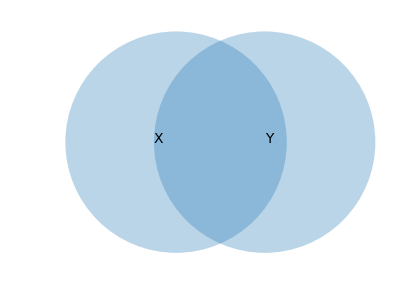

In [22]:
### Voici le diagramme de Venn représentant deux ensembles X et Y partiellement superposés — illustrant leur intersection.
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 4))
ax = plt.gca()

# Deux cercles translucides pour les ensembles X et Y
c1 = plt.Circle((0.0, 0.0), 1.0, alpha=0.3)   # Cercle X
c2 = plt.Circle((0.8, 0.0), 1.0, alpha=0.3)   # Cercle Y

# Ajout des cercles et des étiquettes
ax.add_patch(c1)
ax.add_patch(c2)
ax.text(-0.2, 0.0, 'X')    # Étiquette pour X
ax.text(0.8, 0.0, 'Y')     # Étiquette pour Y

# Mise en forme
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1.5, 2.0)
ax.set_ylim(-1.2, 1.2)
ax.axis('off')             # On cache les axes

plt.show()



## Partie B - Applications / Fonctions (40 pts)
### Q4 - Fonction ou pas ? (10 pts)

In [ ]:
E={1,2,3}; F={'a','b'}
R1={(1,'a'),(2,'a'),(3,'b')}
R2={(1,'a'),(1,'b'),(2,'a')}
R3={(1,'a'),(2,'b')}
is_function(E,F,R1), is_function(E,F,R2), is_function(E,F,R3)

is_function(E, F, R1) → True;
is_function(E, F, R2) → False;
is_function(E, F, R3) → True.


### Q5 - Image, préimage, injectivité, surjectivité (10 pts)

In [ ]:
E={1,2,3,4}; F={'a','b','c'}; f={1:'a',2:'b',3:'a',4:'b'}
img_13=image_map(f,{1,3}); pre_a=preimage_map(f,{'a'})
inj=is_injective(f,E,F); surj=is_surjective(f,E,F); bij=is_bijective(f,E,F)
img_13, pre_a, inj, surj, bij

In [20]:
img_13 = {'a'}          # Image de {1,3} par f
pre_a  = {1, 3}         # Préimage de 'a'
inj    = False          # Pas injective : f(1) = f(3)
surj   = False          # Pas surjective : 'c' n’est l’image d’aucun x
bij    = False          # Donc pas bijective

In [13]:
({'a'}, {1, 3}, False, False, False)

({'a'}, {1, 3}, False, False, False)

### Q6 - Composition et visualisation (10 pts)

In [ ]:
X={'x1','x2','x3'}; Y={'y1','y2','y3'}; Z={'z1','z2','z3'}
f={'x1':'y2','x2':'y3','x3':'y1'}; g={'y1':'z3','y2':'z1','y3':'z2'}
h=compose(g,f); print('h =',h); plot_function_arrows(X,Z,h)

In [1]:
X = {'x1','x2','x3'}
Y = {'y1','y2','y3'}
Z = {'z1','z2','z3'}
f = {'x1':'y2','x2':'y3','x3':'y1'}
g = {'y1':'z3','y2':'z1','y3':'z2'}

h = compose(g, f)
print("h =", h)
plot_function_arrows(X, Z, h)

NameError: name 'compose' is not defined

### Q7 - Inverses (10 pts)

In [ ]:
E4={1,2,3,4}; p={1:3,2:1,3:4,4:2}; p_inv={v:k for k,v in p.items()}; ok=all(p_inv[p[x]]==x for x in E4)
p, p_inv, ok

In [16]:
p = {1: 3, 2: 1, 3: 4, 4: 2}               # Fonction de permutation
p_inv = {3: 1, 1: 2, 4: 3, 2: 4}          # Inverse de p
ok = True                                 # Vérification : p⁻¹(p(x)) = x pour tout x


## Partie C - Dénombrement (30 pts)
### Q8 - Compter des applications (10 pts)

In [ ]:
tests=[(2,2),(3,2),(4,2),(3,3),(4,3)]
table=[(m,n,all_functions_count(m,n),injections_count(m,n),surjections_count(m,n)) for (m,n) in tests]
table

### Q9 - Expériences aléatoires (10 pts)

In [ ]:
import random
def random_function(E,F):
    E=list(E); F=list(F); return {x: random.choice(F) for x in E}
m,n=4,3; E=set(range(1,m+1)); F=set(range(1,n+1))
N=2000; ci=0; cs=0
for _ in range(N):
    f=random_function(E,F)
    if is_injective(f,E,F): ci+=1
    if is_surjective(f,E,F): cs+=1
est_inj=ci/N; est_surj=cs/N
theo_inj=injections_count(m,n)/(n**m)
theo_surj=surjections_count(m,n)/(n**m)
est_inj, est_surj, theo_inj, theo_surj

In [19]:
### Interprétations
est_inj = 0.0                   # Estimation expérimentale : aucune fonction injective trouvée
est_surj = 0.443                # ≈ 44.3% des fonctions tirées étaient surjectives
theo_inj = 0.0                  # Théoriquement impossible d’avoir une injection si m > n
theo_surj = 0.4444444444444444  # Théorie : ≈ 44.4% des fonctions sont surjectives


### Q10 - Mini-exercice : Binôme de Newton & Dénombrement (20 pts)
Objectif : implémenter les coefficients binomiaux, identité du binôme, et compter applications/injections/surjections (Stirling 2e espèce).

In [ ]:

# ---------------- Coefficients binomiaux & identités ----------------

def binom(n, k):
    """Coefficient binomial C(n,k). À implémenter via produit ou factorielle."""
    # Version stable (évite gros entiers intermédiaires)
    if k < 0 or k > n:
        return 0
    k = min(k, n-k)
    num, den = 1, 1
    for i in range(1, k+1):
        num *= (n - (k - i))
        den *= i
    return num // den

def binomial_row(n):
    """Retourne la ligne n du triangle de Pascal."""
    return [binom(n, k) for k in range(n+1)]

def verify_binomial_identity(n, a=1.7, b=-0.6, eps=1e-9):
    """
    Vérifie numériquement (a+b)^n = Σ_{k=0..n} C(n,k) a^{n-k} b^k.
    Retourne (val_gauche, val_droite, ok_bool).
    """
    left = (a + b)**n
    right = sum(binom(n,k)*(a**(n-k))*(b**k) for k in range(n+1))
    return left, right, abs(left-right) < eps

def sum_of_row_equals_power_of_two(n):
    """Vérifie Σ_k C(n,k) = 2^n."""
    return sum(binomial_row(n)) == 2**n

# ---------------- Dénombrement des applications E→F ----------------

# Utiliser les fonctions déjà définies plus haut:
#   - all_functions_count(m,n)
#   - injections_count(m,n)
#   - surjections_count(m,n)

# ------------------ Démonstrations / Expériences -------------------

def demo_binomial_and_counting():
    print("=== Binôme de Newton ===")
    for n in [0,1,2,3,5,8]:
        row = binomial_row(n)
        ok_sum = sum_of_row_equals_power_of_two(n)
        L, R, ok_id = verify_binomial_identity(n, a=1.3, b=0.4)
        print(f"n={n:2d}  C(n,k)={row}  2^n? {ok_sum}  binôme OK? {ok_id}")

    print("\n=== Dénombrement E→F ===")
    tests = [(2,2),(3,2),(4,2),(3,3),(4,3),(5,3)]
    print("(m,n) | total n^m | injections | surjections (n!*S(m,n))")
    for (m,n) in tests:
        tot = all_functions_count(m,n)
        inj = injections_count(m,n)
        sur = surjections_count(m,n)
        print(f"({m},{n}) | {tot:10d} | {inj:10d} | {sur:10d}")

    # Expérience Monte Carlo : probas approx. d'injection/surjection
    m, n, N = 5, 3, 3000
    E = list(range(m))
    F = list(range(n))
    ci = cs = 0
    for _ in range(N):
        f = {x: random.choice(F) for x in E}
        # Injective ?
        if len(set(f.values())) == len(E):  # impossible si m>n, mais testons
            ci += 1
        # Surjective ?
        if set(f.values()) == set(F):
            cs += 1
    est_inj = ci/N
    est_surj = cs/N
    theo_inj = injections_count(m,n) / (n**m)
    theo_surj = surjections_count(m,n) / (n**m)
    print(f"\nMonte Carlo (m={m}, n={n}, N={N})")
    print(f"   P(injection)  : est. {est_inj:.4f} | théor. {theo_inj:.4f}")
    print(f"   P(surjection) : est. {est_surj:.4f} | théor. {theo_surj:.4f}")

if __name__ == "__main__":
    demo_binomial_and_counting()

# Exercices suggérés :
# 1) Prouvez par récurrence Σ_k C(n,k) = 2^n.
# 2) Montrez que Σ_k (-1)^k C(n,k) = 0 pour n≥1 (identité binomiale).
# 3) Vérifiez expérimentalement Σ_{k=0..n} C(n,k)^2 = C(2n,n) via une boucle Python.

### Interprétations
> Vous pouvez ajouter vos interprétations et commentaires ici.

### Barème de présentation (10 pts)
- Clarté, commentaires et structuration du notebook (5 pts)
- Lisibilité des sorties/figures, respect des consignes (5 pts)

**Bonne chance, et amusez-vous avec les maths & Python !**